## Importing the Libraries.

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from scipy.stats import randint as sp_randint
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle
import joblib
from IPython.display import Image


## Uploading the Data

In [2]:
#Loading data
#Loading the Data
train_df = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
piv_train = train_df.shape[0]

In [3]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
train_df.shape

(213451, 16)

In [5]:
train_df.id.value_counts().sum()

213451

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

## User Details

In [7]:
sessions_df  = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')

In [8]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [9]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [10]:
sessions_df.shape

(10567737, 6)

## Preprocessing

In [11]:
sessions_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
sessions_df["action_type"].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [13]:
sessions_df["action"].value_counts()

show              2768278
index              843699
search_results     725226
personalize        706824
search             536057
                   ...   
deauthorize             1
events                  1
reactivate              1
desks                   1
nyan                    1
Name: action, Length: 359, dtype: int64

## Feature Engineering

In [14]:
sessions_df = sessions_df.groupby("user_id", as_index= False).agg(lambda x:x.tolist())

In [15]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"[index, dashboard, header_userpic, dashboard, ...","[view, view, data, view, partner_callback, mes...","[view_search_results, dashboard, header_userpi...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[20438.0, 787.0, 850.0, 934.0, nan, 129817.0, ..."
1,0010k6l0om,"[search_results, show, personalize, show, sear...","[click, view, data, nan, click, click, nan, da...","[view_search_results, p3, wishlist_content_upd...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De...","[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,..."
2,001wyh0pz8,"[search, search, search, show, social_connecti...","[click, click, click, view, data, -unknown-, v...","[view_search_results, view_search_results, vie...","[Android App Unknown Phone/Tablet, Android App...","[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ..."
3,0028jgx1x1,"[show, reviews, show, search, show, search, re...","[view, data, view, click, view, click, data, s...","[user_profile, listing_reviews, p3, view_searc...","[-unknown-, -unknown-, -unknown-, -unknown-, -...","[6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0..."
4,002qnbzfs5,"[social_connections, payment_methods, create, ...","[data, -unknown-, -unknown-, view, data, data,...","[user_social_connections, -unknown-, -unknown-...","[iPhone, iPhone, iPhone, iPhone, iPhone, iPhon...","[17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782..."


### Converting the list to string.

In [16]:
def convert_to_string(action):
    action = [str(i) for i in action]
    action = [re.sub("nan","",i) for i in action]
    action = ",".join(action)
    
    return action

In [17]:
sessions_df["action"] = sessions_df["action"].apply(convert_to_string)
sessions_df["action_type"] = sessions_df["action_type"].apply(convert_to_string)
sessions_df["action_detail"] = sessions_df["action_detail"].apply(convert_to_string)


In [18]:
sessions_df.isnull().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

### Conversion to set

In [19]:
def convert_to_set(device):
    device = [str(i) for i in device]
    device = [re.sub("nan","",i) for i in device]
    device = ",".join(set(device))
    
    return device

In [20]:
sessions_df['device_type'] =sessions_df['device_type'].apply(convert_to_set)

### Convert list to time

In [21]:
def convert_the_time(time):
    
    float_time = []
    time = [str(i) for i in time]
    time = [re.sub("nan","",i) for i in time]
    
    for i in time:
        try:
            float_time.append(float(i))
        except ValueError :
            continue


    time = sum(float_time)
    
    return time

In [22]:
sessions_df['secs_elapsed'] = sessions_df['secs_elapsed'].apply(convert_the_time)

#### Revised sessions dataframe

In [23]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"index,dashboard,header_userpic,dashboard,callb...","view,view,data,view,partner_callback,message_p...","view_search_results,dashboard,header_userpic,d...","Mac Desktop,iPhone",867896.0
1,0010k6l0om,"search_results,show,personalize,show,search_re...","click,view,data,,click,click,,data,view,partne...","view_search_results,p3,wishlist_content_update...",Mac Desktop,586543.0
2,001wyh0pz8,"search,search,search,show,social_connections,i...","click,click,click,view,data,-unknown-,view,-un...","view_search_results,view_search_results,view_s...",Android App Unknown Phone/Tablet,282965.0
3,0028jgx1x1,"show,reviews,show,search,show,search,reviews,c...","view,data,view,click,view,click,data,submit,-u...","user_profile,listing_reviews,p3,view_search_re...","Android Phone,-unknown-",297010.0
4,002qnbzfs5,"social_connections,payment_methods,create,show...","data,-unknown-,-unknown-,view,data,data,data,,...","user_social_connections,-unknown-,-unknown-,us...","iPhone,-unknown-",6487080.0


In [24]:
sessions_df.shape

(135483, 6)

## Merge the two tables

In [25]:
# Join train and session df

train_merge = train_df.merge(sessions_df, left_on='id', right_on='user_id', how='left')

print("Train  :",train_df.shape)

print("Session:",sessions_df.shape)

print("Merge  :",train_merge.shape)

print("No of users in Train Data with session info:",train_merge.shape[0])

print("{} / {} = {}".format(train_merge.shape[0],train_df.shape[0],np.round((train_merge.shape[0]/train_df.shape[0]),2)))

Train  : (213451, 16)
Session: (135483, 6)
Merge  : (213451, 22)
No of users in Train Data with session info: 213451
213451 / 213451 = 1.0


In [26]:
train_merge.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
user_id                    139636
action                     139636
action_type                139636
action_detail              139636
device_type                139636
secs_elapsed               139636
dtype: int64

In [27]:
train_merge.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,user_id,action,action_type,action_detail,device_type,secs_elapsed
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,...,Web,Mac Desktop,Safari,NDF,zxodksqpep,"edit,edit,handle_vanity_url,edit,references,re...","view,view,-unknown-,view,view,view,-unknown-,-...","edit_profile,edit_profile,-unknown-,edit_profi...","Mac Desktop,iPhone",5141396.0
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,...,Web,Windows Desktop,Chrome,NDF,mhewnxesx9,"confirm_email,dashboard,header_userpic,dashboa...","click,view,data,view,submit,view,view,data,vie...","confirm_email_link,dashboard,header_userpic,da...","Mac Desktop,Windows Desktop,iPhone",2878924.0
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,...,Web,Mac Desktop,Firefox,NDF,6o3arsjbb4,"ajax_refresh_subtotal,ajax_refresh_subtotal,si...","click,click,data,,data,data,,view,view,view,vi...","change_trip_characteristics,change_trip_charac...",Mac Desktop,342982.0
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,...,iOS,iPhone,Mobile Safari,NDF,jh95kwisub,"search,search,search,search,search,search,camp...","click,click,click,click,click,click,,-unknown-...","view_search_results,view_search_results,view_s...",iPhone,341609.0
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,...,iOS,iPhone,-unknown-,NDF,nw9fwlyb5f,"show,show,reviews,campaigns,click,campaigns,ac...","view,view,data,,click,,-unknown-,-unknown-,,-u...","user_profile,p3,listing_reviews,,book_it,,-unk...",iPhone,2759210.0


### Read Test data

In [28]:
test_df  = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
id_test = test_df['id']


In [29]:
test_df.age

0        35.0
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
62091    31.0
62092     NaN
62093     NaN
62094     NaN
62095    49.0
Name: age, Length: 62096, dtype: float64

In [30]:
test_df.shape

(62096, 15)

In [31]:
print("Train data columns : ", train_df.columns)
print("Test data columns : ", test_df.columns)

Train data columns :  Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')
Test data columns :  Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')


In [32]:
test_df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

### Merging the test with session df.

In [33]:
test_merge = test_df.merge(sessions_df, left_on= "id", right_on="user_id", how = "inner")
print("test:", test_df.shape)
print("sessions_df:", sessions_df.shape)
print("test_merge:", test_merge.shape)
print("{} / {} = {}".format(test_merge.shape[0],test_df.shape[0],np.round((test_merge.shape[0]/test_df.shape[0]),2)))

test: (62096, 15)
sessions_df: (135483, 6)
test_merge: (61668, 21)
61668 / 62096 = 0.99


    1 % of the test data don't have sessions details
    
    we will use left join

In [34]:
test_merge = test_df.merge(sessions_df, left_on= "id", right_on="user_id", how = "left")
print("test:", test_df.shape)
print("sessions_df:", sessions_df.shape)
print("test_merge:", test_merge.shape)
print("{} / {} = {}".format(test_merge.shape[0],test_df.shape[0],np.round((test_merge.shape[0]/test_df.shape[0]),2)))

test: (62096, 15)
sessions_df: (135483, 6)
test_merge: (62096, 21)
62096 / 62096 = 1.0


In [35]:
#Checking null values
test_merge.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
user_id                      428
action                       428
action_type                  428
action_detail                428
device_type                  428
secs_elapsed                 428
dtype: int64

    we will have 428 row with no sessions informations >> 428 null values ( 1% )

### Data Cleaning

Filling the null values:

For string cols fillna with 'na' and for int col('secs_elapsed') fillna with 0.

In [36]:
test_merge["user_id"].fillna("na", inplace = True)
test_merge["action"].fillna("na", inplace = True)
test_merge["action_type"].fillna("na", inplace = True)
test_merge["action_detail"].fillna("na", inplace = True)
test_merge["device_type"].fillna("na", inplace = True)
test_merge["secs_elapsed"].fillna(0, inplace = True)

train_merge["user_id"].fillna("na", inplace = True)
train_merge["action"].fillna("na", inplace = True)
train_merge["action_type"].fillna("na", inplace = True)
train_merge["action_detail"].fillna("na", inplace = True)
train_merge["device_type"].fillna("na", inplace = True)
train_merge["secs_elapsed"].fillna(0, inplace = True)

test_merge["age"].fillna(34.0, inplace = True)
train_merge["age"].fillna(34.0, inplace = True)


In [37]:
test_merge.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
user_id                        0
action                         0
action_type                    0
action_detail                  0
device_type                    0
secs_elapsed                   0
dtype: int64

In [38]:
test_merge.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,"show,search,search,show,authenticate,reviews,a...","view,click,click,view,submit,data,-unknown-,click","user_profile,view_search_results,view_search_r...","iPhone,-unknown-",119187.0
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,34.0,basic,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,jtl0dijy2j,"dashboard,login,search,create,search,signup_lo...","view,view,click,submit,click,view,-unknown-,vi...","dashboard,login_page,view_search_results,creat...","iPhone,-unknown-",250119.0
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,34.0,basic,0,en,direct,...,linked,Web,Windows Desktop,Chrome,xx0ulgorjt,"index,index,index,search_results,search_result...","view,view,view,click,click,click,click,data,vi...","view_search_results,view_search_results,view_s...",Windows Desktop,975575.0
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,34.0,basic,0,en,direct,...,linked,Web,Windows Desktop,IE,6c6puo6ix0,"personalize,header_userpic,header_userpic,show...","data,data,data,view,view,,data,click,submit,,data","wishlist_content_update,header_userpic,header_...",Windows Desktop,123001.0
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,34.0,basic,0,en,direct,...,untracked,Web,Mac Desktop,Safari,czqhjk3yfe,"message_to_host_change,agree_terms_check,pendi...","click,-unknown-,booking_request,message_post,v...","message_to_host_change,-unknown-,pending,messa...",Mac Desktop,454023.0


## Splitting the date.

Splitting the date format yyyy-mm-dd into weekdays, month and year using dt.weekdays. 

In [39]:
train_merge["date_account_created"] = pd.to_datetime(train_merge["date_account_created"])
train_merge["date_account_created_day"] = train_merge.date_account_created.dt.weekday
train_merge["date_account_created_month"] = train_merge.date_account_created.dt.month
train_merge["date_account_created_year"] = train_merge.date_account_created.dt.year

test_merge["date_account_created"] = pd.to_datetime(test_merge["date_account_created"])
test_merge["date_account_created_day"] = test_merge.date_account_created.dt.weekday
test_merge["date_account_created_month"] = test_merge.date_account_created.dt.month
test_merge["date_account_created_year"] = test_merge.date_account_created.dt.year

## setting the time stamp

In [40]:
def convert_timestamp_first_active(timestamp):
        
        timestamp = str(timestamp)
        
        timestamp = datetime(year=int(timestamp[0:4]), month=int(timestamp[4:6]), day=int(timestamp[6:8]),\
                             
                             hour=int(timestamp[8:10]), minute=int(timestamp[10:12]), second=int(timestamp[12:]))
        
        return timestamp

In [41]:
train_merge['timestamp_first_active'] = pd.to_datetime(train_merge.timestamp_first_active.apply(convert_timestamp_first_active))
train_merge["timestamp_first_active_day"] = train_merge.timestamp_first_active.dt.weekday
train_merge["timestamp_first_active_month"] = train_merge.timestamp_first_active.dt.month
train_merge["timestamp_first_active_year"] = train_merge.timestamp_first_active.dt.year
train_merge["timestamp_first_active_hour"] = train_merge.timestamp_first_active.dt.hour

test_merge['timestamp_first_active'] = pd.to_datetime(test_merge.timestamp_first_active.apply(convert_timestamp_first_active))
test_merge['timestamp_first_active_day'] = test_merge.timestamp_first_active.dt.weekday
test_merge['timestamp_first_active_month'] = test_merge.timestamp_first_active.dt.month
test_merge['timestamp_first_active_year'] = test_merge.timestamp_first_active.dt.year
test_merge['timestamp_first_active_hour'] = test_merge.timestamp_first_active.dt.hour 

## Visualizing the data.

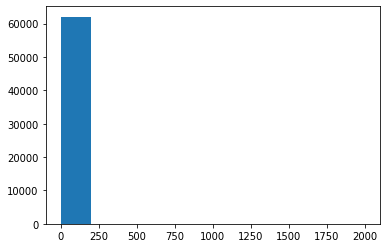

In [42]:
plt.hist(test_merge["age"])
plt.show()

## Applying the median age.

In [43]:
def median_age(age):
    
    if age< 15.0 or age > 100.0:
        return 34.0
    else:
        return age
    

In [44]:
train_merge["age"] = train_merge["age"].apply(median_age)

test_merge["age"] = test_merge["age"].apply(median_age)

In [45]:
test_merge['age']

0        35.0
1        34.0
2        34.0
3        34.0
4        34.0
         ... 
62091    31.0
62092    34.0
62093    34.0
62094    34.0
62095    49.0
Name: age, Length: 62096, dtype: float64

### Creating the age bucket.

In [46]:
bins = [i for i in range (15,106,5)]

def make_age_buckets(age):
    
    for i in range (len(bins)):
        if age < bins[i]:
            return i

In [47]:
train_merge['age'] = train_merge['age'].apply(lambda x :make_age_buckets(x))
test_merge['age'] = test_merge['age'].apply(lambda x :make_age_buckets(x))

In [48]:
train_merge.isnull().sum()

id                                   0
date_account_created                 0
timestamp_first_active               0
date_first_booking              124543
gender                               0
age                                  0
signup_method                        0
signup_flow                          0
language                             0
affiliate_channel                    0
affiliate_provider                   0
first_affiliate_tracked           6065
signup_app                           0
first_device_type                    0
first_browser                        0
country_destination                  0
user_id                              0
action                               0
action_type                          0
action_detail                        0
device_type                          0
secs_elapsed                         0
date_account_created_day             0
date_account_created_month           0
date_account_created_year            0
timestamp_first_active_da

### Mode replacement for first_affiliate_tracked

In [49]:
# mode replacement for first_affiliate_tracked
train_merge.first_affiliate_tracked.fillna('untracked',inplace = True)

test_merge.first_affiliate_tracked.fillna('untracked',inplace = True)

In [50]:
train_merge.shape

(213451, 29)

In [51]:
test_merge.shape

(62096, 28)

## One Hot Encoding


In [52]:
# make one hot encoded columns

lst_ohe_train =[]
ohe = ['gender', 'signup_method', 'language', 'affiliate_channel',\
            'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for col in ohe:
    train_ohe = pd.get_dummies(train_merge[col],prefix = col)
    train_merge.drop([col], axis = 1, inplace = True)
    
    test_ohe = pd.get_dummies(test_merge[col], prefix = col)
    test_merge.drop([col], axis = 1, inplace = True)
    
    lst_ohe_train.append(train_ohe.columns)
    
    # Get missing columns in the training test
    
    missing_cols = set( train_ohe.columns ) - set( test_ohe.columns )
    
    # Add a missing column in test set with default value equal to 0
    
    for c in missing_cols:
        
        test_ohe[c] = 0
        
    # Ensure the order of column in the test set is in the same order than in train set
    
    test_ohe = test_ohe[train_ohe.columns]
    
    train_merge = pd.concat((train_merge, train_ohe), axis=1)    
        
    test_merge = pd.concat((test_merge, test_ohe), axis=1)

In [53]:
# OHE device_type

train_ohe = train_merge['device_type'].str.get_dummies(sep=",")
    
train_merge.drop(['device_type'], axis=1, inplace = True)
    
test_ohe = test_merge['device_type'].str.get_dummies(sep=",")
    
test_merge.drop(['device_type'], axis=1, inplace = True)
        
# Get missing columns in the training test
    
missing_cols = set( train_ohe.columns ) - set( test_ohe.columns )

lst_ohe_train.append(train_ohe.columns)
    
# Add a missing column in test set with default value equal to 0
    
for c in missing_cols:
        
    test_ohe[c] = 0
        
# Ensure the order of column in the test set is in the same order than in train set
    
test_ohe = test_ohe[train_ohe.columns]
    
train_merge = pd.concat((train_merge, train_ohe), axis=1)    
        
test_merge = pd.concat((test_merge, test_ohe), axis=1)

In [54]:
y = train_merge['country_destination']

## Dropping the columns.

In [55]:
# drop colmns

train_merge.drop(['id','date_account_created','timestamp_first_active',\
                  'date_first_booking','country_destination','user_id'],axis=1,inplace = True)

test_merge.drop(['id','date_account_created','timestamp_first_active',\
                  'date_first_booking','user_id'],axis=1,inplace = True)

In [56]:
print(train_merge.shape)
print(test_merge.shape)

(213451, 158)
(62096, 158)


In [57]:
print(train_merge.columns)

train_merge.head()

Index(['age', 'signup_flow', 'action', 'action_type', 'action_detail',
       'secs_elapsed', 'date_account_created_day',
       'date_account_created_month', 'date_account_created_year',
       'timestamp_first_active_day',
       ...
       'Linux Desktop', 'Mac Desktop', 'Opera Phone', 'Tablet',
       'Windows Desktop', 'Windows Phone', 'iPad Tablet', 'iPhone',
       'iPodtouch', 'na'],
      dtype='object', length=158)


,age,signup_flow,action,action_type,action_detail,secs_elapsed,date_account_created_day,date_account_created_month,date_account_created_year,timestamp_first_active_day,...,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,na
0,4,0,na,na,na,0.0,0,6,2010,3,...,0,0,0,0,0,0,0,0,0,1
1,5,0,na,na,na,0.0,2,5,2011,5,...,0,0,0,0,0,0,0,0,0,1
2,9,3,na,na,na,0.0,1,9,2010,1,...,0,0,0,0,0,0,0,0,0,1
3,6,0,na,na,na,0.0,0,12,2011,5,...,0,0,0,0,0,0,0,0,0,1
4,6,0,na,na,na,0.0,1,9,2010,1,...,0,0,0,0,0,0,0,0,0,1


In [58]:
train_merge.isnull().sum()

age              0
signup_flow      0
action           0
action_type      0
action_detail    0
                ..
Windows Phone    0
iPad Tablet      0
iPhone           0
iPodtouch        0
na               0
Length: 158, dtype: int64

In [59]:
test_merge.isnull().sum()

age              0
signup_flow      0
action           0
action_type      0
action_detail    0
                ..
Windows Phone    0
iPad Tablet      0
iPhone           0
iPodtouch        0
na               0
Length: 158, dtype: int64

In [60]:
train_merge.age

0         4
1         5
2         9
3         6
4         6
         ..
213446    4
213447    4
213448    4
213449    4
213450    4
Name: age, Length: 213451, dtype: int64

## Tokenization and TF-IDF

In [61]:
def tokens(x):
    return x.split(',')

In [62]:
# TF-IDF for action

vectorizer_action = TfidfVectorizer(min_df= 10, max_features = 5000, tokenizer= tokens)
vectorizer_action.fit(train_merge["action"].values)

train_action_tfidf = vectorizer_action.transform(train_merge.action.values)
test_action_tfidf = vectorizer_action.transform(test_merge["action"].values)

print(train_action_tfidf.shape)
print(test_action_tfidf.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(213451, 257)
(62096, 257)


In [63]:
# TF-IDF for action type

vectorizer_action_type =TfidfVectorizer(min_df = 10, max_features= 5000, tokenizer= tokens)
vectorizer_action_type.fit(train_merge["action_type"].values)

train_action_type_tfidf = vectorizer_action_type.transform(train_merge["action_type"].values)
test_action_type_tfidf = vectorizer_action_type.transform(test_merge["action_type"].values)

print(train_action_type_tfidf.shape)
print(test_action_type_tfidf.shape)


(213451, 10)
(62096, 10)


In [64]:
# TF-IDF for action type

vectorizer_action_detail =TfidfVectorizer(min_df = 10, max_features= 5000, tokenizer= tokens)
vectorizer_action_detail.fit(train_merge["action_detail"].values)

train_action_detail_tfidf = vectorizer_action_detail.transform(train_merge["action_detail"].values)
test_action_detail_tfidf = vectorizer_action_detail.transform(test_merge["action_detail"].values)

print(train_action_detail_tfidf.shape)
print(test_action_detail_tfidf.shape)


(213451, 123)
(62096, 123)


In [65]:
# drop columns

train_merge.drop(['action','action_type','action_detail'],axis=1,inplace = True)

test_merge.drop(['action','action_type','action_detail'],axis=1,inplace = True)

In [66]:
col_lst = [i for i in train_merge.columns]

col_lst

['age',
 'signup_flow',
 'secs_elapsed',
 'date_account_created_day',
 'date_account_created_month',
 'date_account_created_year',
 'timestamp_first_active_day',
 'timestamp_first_active_month',
 'timestamp_first_active_year',
 'timestamp_first_active_hour',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_en',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',
 'language_zh',
 'affiliate_channel_api',
 'affiliate_channel_content',
 'affiliate_channel_direct',
 'affiliate_channel_other',
 'affiliate_channel_remarketing',
 'affiliate_channel_sem-brand',
 'affiliate_ch

### Data Stacking

What is stacking?
        A stack is a linear data structure that stores items in a Last-In/First-Out (LIFO) or First-In/Last-Out (FILO) manner. In stack, a new element is added at one end and an element is removed from that end only. The insert and delete operations are often called push and pop.

>hstack() function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array

In [67]:
train_merge_tfidf = hstack((train_merge, train_action_tfidf,train_action_type_tfidf, train_action_detail_tfidf)).tocsr()
test_merge_tfidf = hstack((test_merge, test_action_tfidf,test_action_type_tfidf, test_action_detail_tfidf)).tocsr()


In [68]:
test_merge_tfidf.get_shape()

(62096, 545)

# Training

In [69]:
le = LabelEncoder()

y = le.fit_transform(y)

In [70]:
# https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [71]:
# param_grid = {
# 'max_depth': sp_randint(3, 20),
# 'learning_rate': [0.001, 0.01, 0.1, 0.2],
# 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# 'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
# 'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
# 'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
# 'n_estimators':[100,200,500,1000,2000],
# 'colsample_bytree':[0.1,0.3,0.5,1],
# 'colsample_bylevel':[0.1,0.3,0.5,1]
# }


# gb = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')

# clf = RandomizedSearchCV(gb, param_grid,n_jobs=-1,verbose=10,scoring=ndcg_scorer, random_state=42)

In [72]:
# clf.fit(train_merge_tfidf,y)

## Model: XGBoost

In [73]:
gb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, n_estimators=100, n_jobs=-1, objective='multi:softmax', random_state=0,
                       reg_lambda=1, subsample=1)

In [74]:
 X_train, X_test, y_train,y_test = train_test_split(train_merge_tfidf,y, test_size =0.25 , random_state = 42)

In [75]:
gb.fit(train_merge_tfidf,y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [76]:
pred_y = gb.predict_proba(test_merge_tfidf)


In [77]:
pred_y


array([[0.00222672, 0.00259246, 0.002757  , ..., 0.00114729, 0.1921663 ,
        0.02608925],
       [0.00149392, 0.00210051, 0.001565  , ..., 0.00100459, 0.09370803,
        0.01806295],
       [0.00128553, 0.00429311, 0.00208586, ..., 0.00078386, 0.10270995,
        0.02430188],
       ...,
       [0.0017581 , 0.00554607, 0.00473228, ..., 0.00105501, 0.09701517,
        0.0293187 ],
       [0.00144223, 0.00409297, 0.00203668, ..., 0.00086384, 0.10951518,
        0.0211065 ],
       [0.00239299, 0.00725465, 0.00825661, ..., 0.00155823, 0.34781465,
        0.05438883]], dtype=float32)

In [78]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()

## Result

In [79]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)

In [80]:
sub.head(20)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT
